# Read observational data from weather mast at Haukeliseter site

Needed for the plot:
- precipitation
- temperature
- wind speed
- wind direction


In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib import gridspec
import numpy as np 
import csv
import pandas as pd
import datetime
from datetime import date
import calendar
import math



%matplotlib inline 

In [22]:
# Autolabel bar plots
def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.05)
        else:
            label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%.1f' % (height),
                ha='center', va='bottom', fontsize=24)

In [23]:
import warnings

x = np.ones((1000, 1000)) * np.nan

# I expect to see RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    foo = np.nanmean(x, axis=0)

In [24]:
### define colors for colorbar
champ = 255
blue = np.array([1,74,159])/champ           # for the date



In [25]:
### Mean wind speed and direction
# http://www.intellovations.com/2011/01/16/wind-observation-calculations-in-fortran-and-python/


In [26]:
Haukeli = pd.read_csv('../Retrieval/201612.Haukeliseter_SC_copy.txt',\
                    sep = ',',header=0)

In [27]:
dd = Haukeli['Date']
time = Haukeli['TimeStamp']     # Time Stamp
dofe1 = Haukeli['RA1'].astype(float)            # total accumulation from Geonor inside DOUBLE FENCE [mm] RA1
dofe2 = Haukeli['RA2'].astype(float)
dofe3 = Haukeli['RA3'].astype(float)
temp = Haukeli['TA'].astype(float)            # Air temperature, PT100 [deg C] 
#speed = Haukeli['FFL4'].astype(float)          # wind speed 4.5m inside DF [m/s]
#direction = Haukeli['DDL4'].astype(float)          # wind direction 4.5m inside DF [deg]

speed = Haukeli['FF'].astype(float)         # wind speed 10 m @ mast 1 [m/s] FF
direction = Haukeli['DD'].astype(float)     # wind direction 10 m @mast 1 [deg] DD

In [28]:
dd[::1440]
year = np.empty((1,31))
month = np.empty((1,31))
day = np.empty((1,31))
for k in range(0,31):
    idx = datetime.datetime.strptime(str(dd[k*1440]), '%Y%m%d')
    year[:,k] = int(idx.year)
    month[:,k] = int(idx.month)
    day[:,k] = int(idx.day)



In [29]:
dofe1 = dofe1.where(dofe1 != -999.00)
dofe2 = dofe2.where(dofe2 != -999.00)
dofe3 = dofe3.where(dofe3 != -999.00)
temp = temp.where(temp != -999.00)
speed = speed.where(speed != -999.00)
direction = direction.where(direction != -999.00)

In [30]:
# --------- TEMP, WS, WD, ACC every 15 min in  -------------------------------------------------------------------------
idx = np.arange((1440))
t = np.empty((1440,32))
ws = np.empty((1440,31))
wd = np.empty((1440,31))


for i in range(0,31):
    t[:,i] = temp[i*1440:(i+1)*1440]
    ws[:,i] = speed[i*1440 : (i+1)*1440]
    wd[:,i] = direction[i*1440 : (i+1)*1440]
    
    
min_15 = np.empty((96,1))
min_60 = np.empty((24,1))

t_15 = np.empty((15,96))
t_15[:] = np.NAN
t_mean = np.empty((96,32))
t_mean[:] = np.NAN





for k in range(0,32):
    for i in range(0,96):
        min_15[i,:] = (1/60.)*float(i)
        # Temperature
        t_15[:,i] = (t[i*15:(i+1)*15, k ])     # first day, every 15 min values as column
        t_mean[:,k] = np.nanmean(t_15,axis=0)   # axis = 0 will return the mean of every single column
        # Wind Speed
    



/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


In [31]:
### calculate the U, V wind component for barb plot
# http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html

# first calculate the mathematical wind direction in deg
md_deg = 270 - wd
for i in range(0,1440):
    for k in range(0,31):
        if md_deg[i,k] < 0:
            md_deg[i,k] = md_deg[i,k] +360
# convert angle to radians
md_rad = math.pi/180. * md_deg

# calculate U component
u_wind = ws * np.cos(md_rad)
# calculate V component
v_wind = ws * np.sin(md_rad)


In [32]:
### average U, and V component in 60 min interval
u_wind60 = np.empty((60,24))
u_wind60[:] = np.NAN

u_wind_mean = np.empty((24,31))
u_wind_mean[:] = np.NAN

v_wind60 = np.empty((60,24))
v_wind60[:] = np.NAN

v_wind_mean = np.empty((24,31))
v_wind_mean[:] = np.NAN

for k in range(0,31):
    for i in range(0,24):
        u_wind60[:,i]  = u_wind[i*60 : (i+1)*60, k]
        u_wind_mean[:,k] = np.nanmean(u_wind60,axis=0)

        v_wind60[:,i]  = v_wind[i*60 : (i+1)*60, k]
        v_wind_mean[:,k] = np.nanmean(v_wind60,axis=0)

# X, y values for barb plotting
X =np.arange(0.5*1/60,1/60*24,1/60)    
Y = np.zeros((min_60.shape))



/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


In [33]:
# --------- SET DAYS WHERE 1440 MIN PER 24H ----------------------------------------------
dy = np.zeros((32,1))

for i in range(0,32):
    dy[i,:] = i*1440.     # begin of the new day 00:00:00

#print(dy)


In [34]:
# --------- CALCULATE ACCUMULATION DURING A GIVEN DAY ------------------------------------
dofe = np.c_[dofe1, dofe2, dofe3]

# axis=1 will return the mean of every single row in the DataFrame
dfavg = np.nanmean(dofe, axis = 1)       # arithmetic mean of the total accumulation DOUBLE FENCE for each minute

dfavg_days = np.empty((1440,31))         # create array with 0-24h in rows, and days in column
dfavg_days[:] = np.NAN

for i in range(0,31):
    dfavg_days[:,i] = dfavg[int(dy[i,:]) : int(dy[i+1,:])] 
    

#dfavg_days[:,30]   # 31th Dec

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [35]:
                                                            # of the three double fence values per minute
min_60 = np.empty((24,1))

df_60 = np.empty((24,31))
df_60[:] = np.NAN

for k in range(0,31):
    for i in range(0,24):
        min_60[i,:] = (1/60)*float(i)
        # Double fence 
        df_60[i,k] = dfavg_days[i*60+59,k] - dfavg_days[i*60,k]



In [36]:
UTC = [1/60*float(0), \
       1/60*float(3), \
       1/60*float(6), \
       1/60*float(9), \
       1/60*float(12), \
       1/60*float(15), \
       1/60*float(18), \
       1/60*float(21), \
       1/60*float(24)]
timer = ['00Z', '03Z','06Z','09Z','12Z','15Z','18Z','21Z','24Z']

prec_tick = np.arange(round(np.nanmin(df_60))-1.,round(np.nanmax(df_60))+0.5,0.5)
T = np.arange(round(np.nanmin(t_mean)-1),round(np.nanmax(t_mean)+1),2)

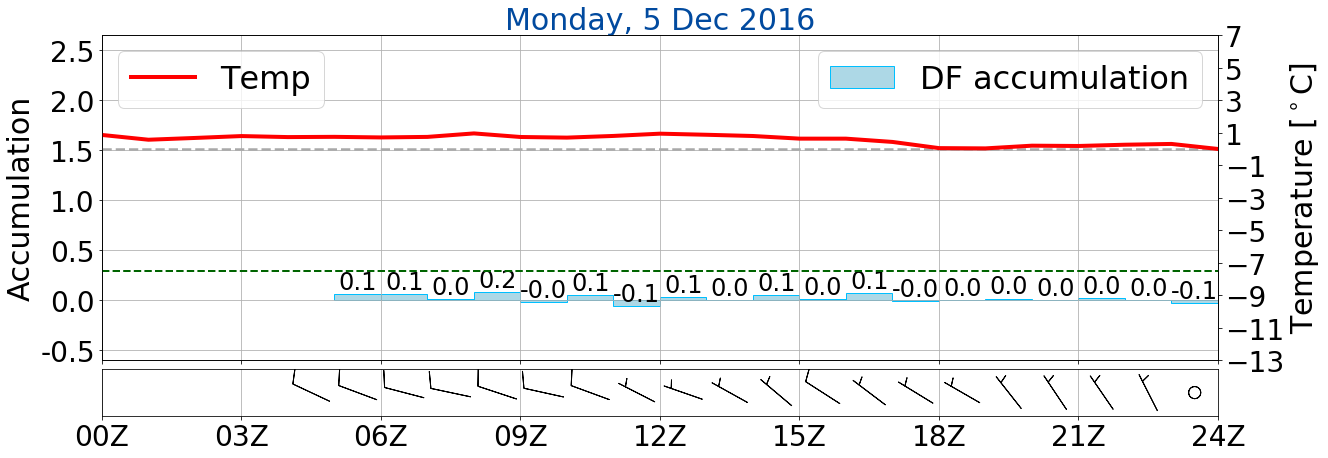

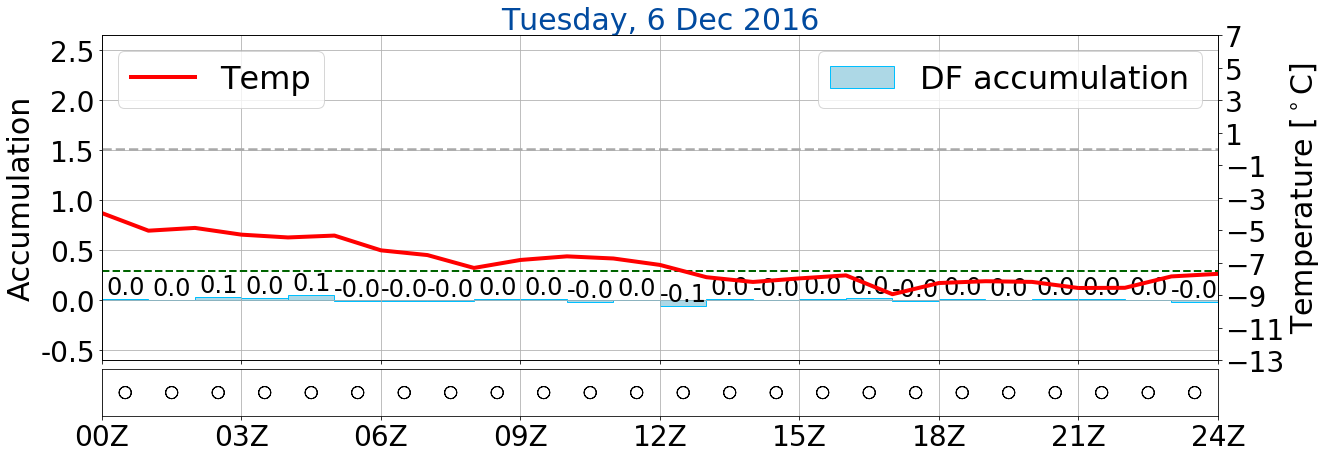

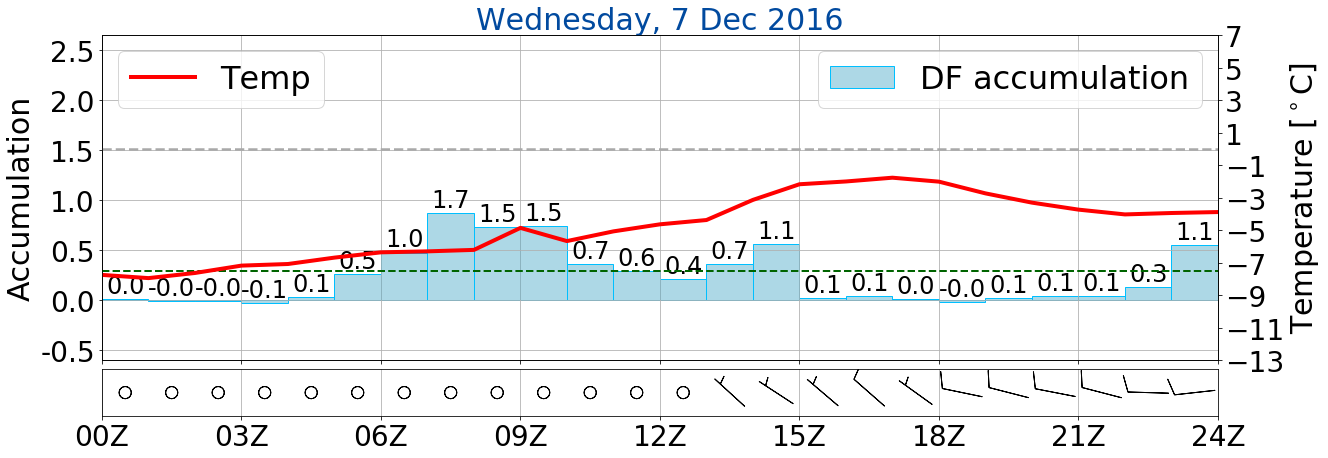

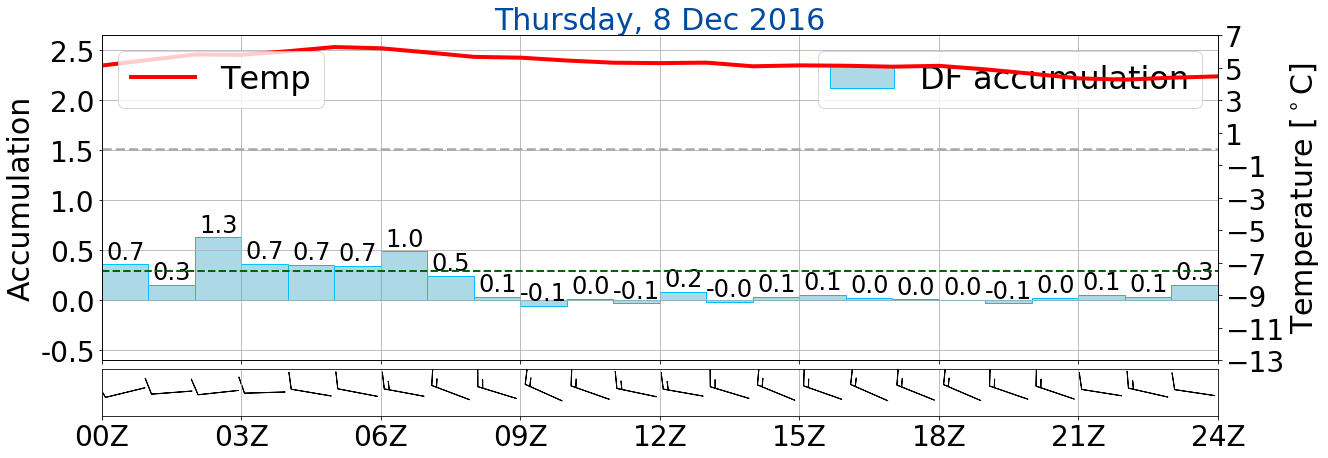

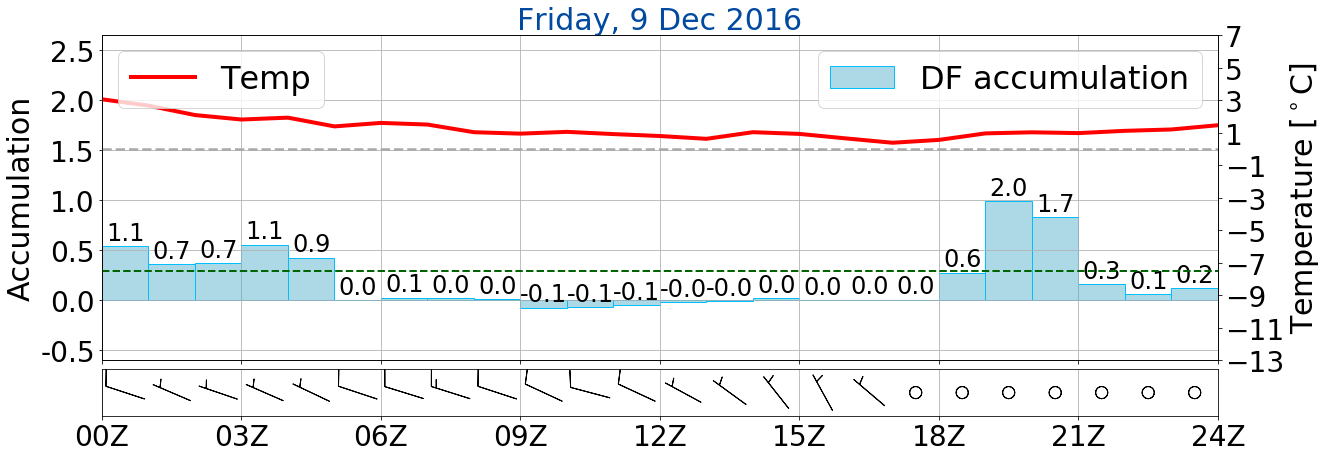

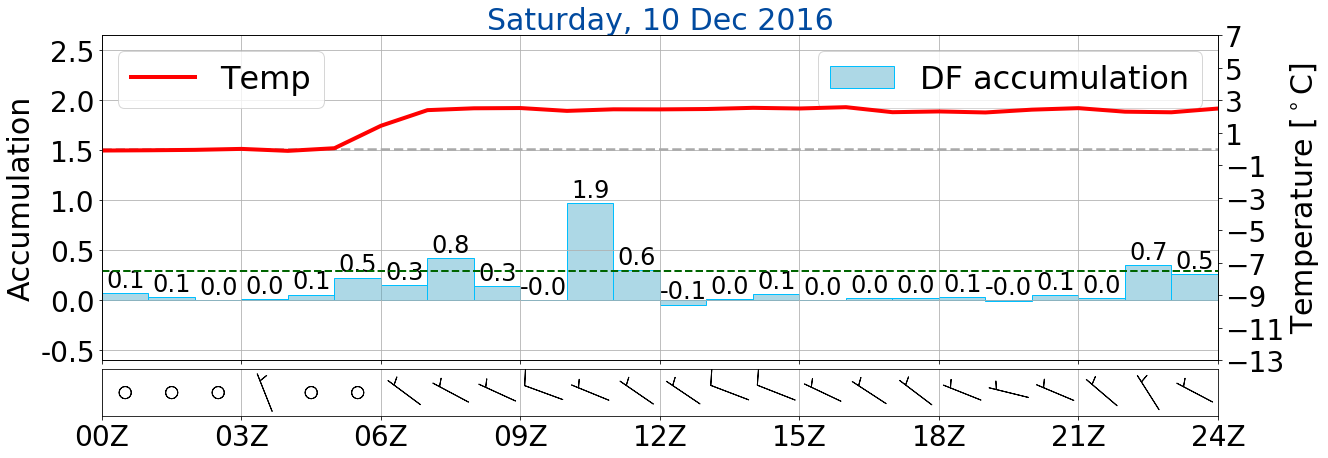

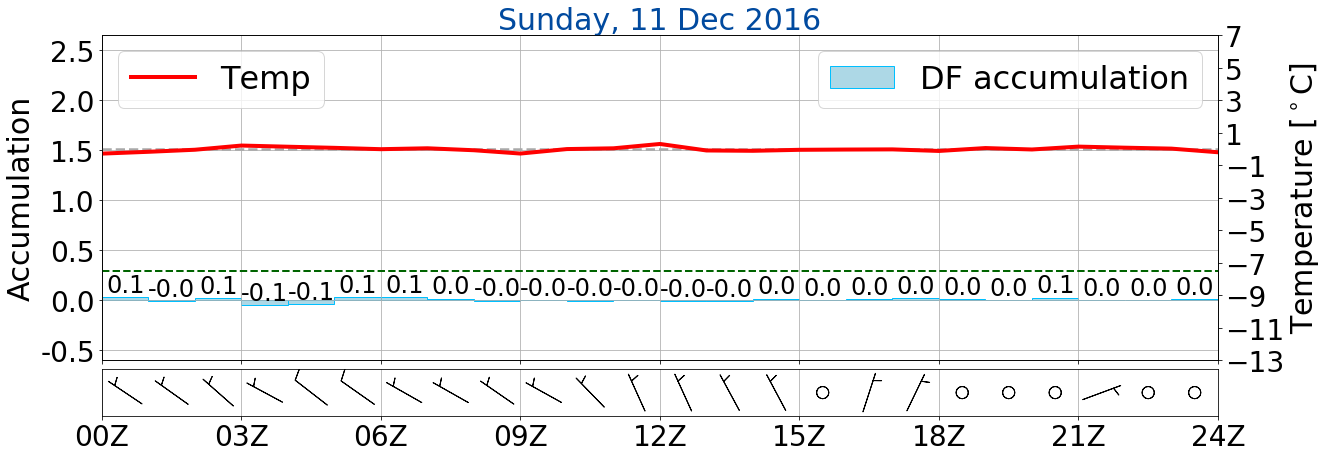

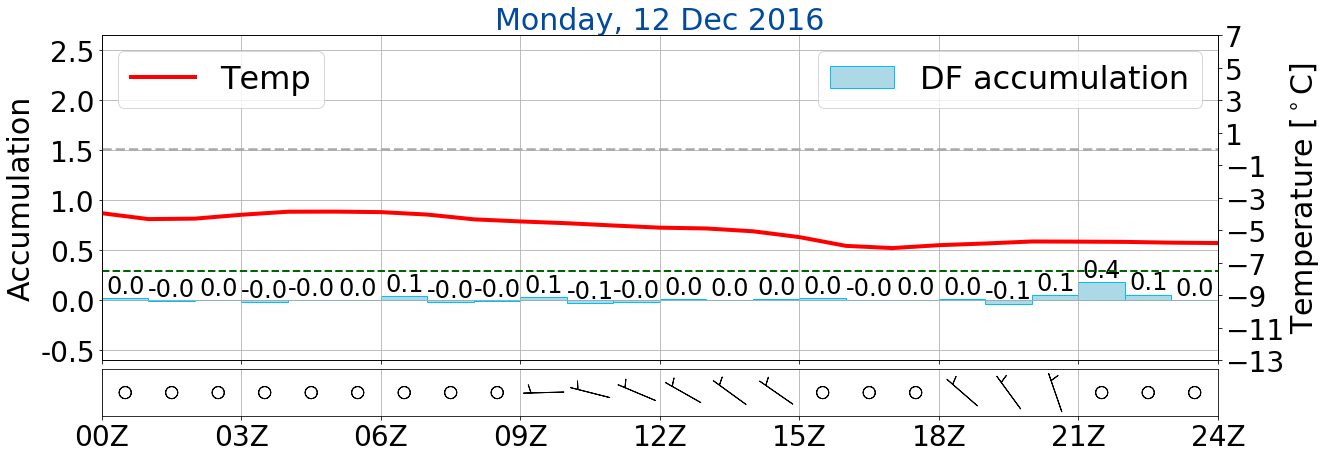

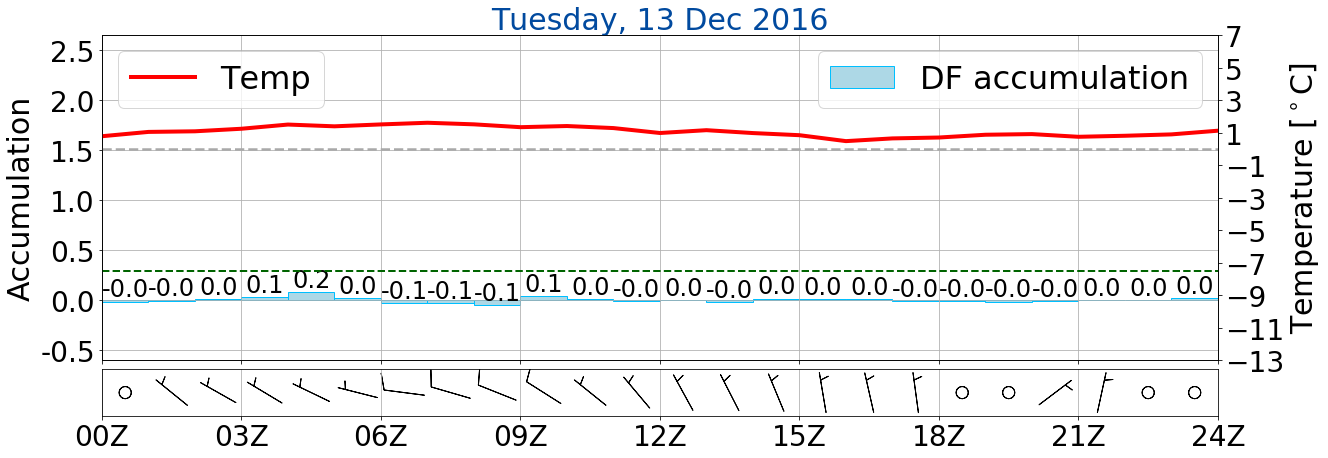

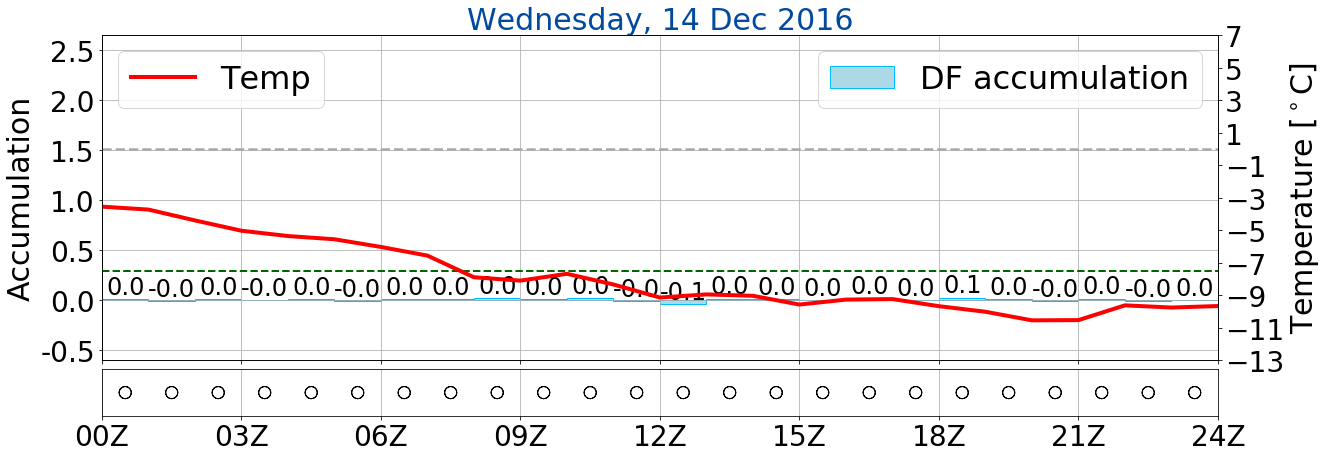

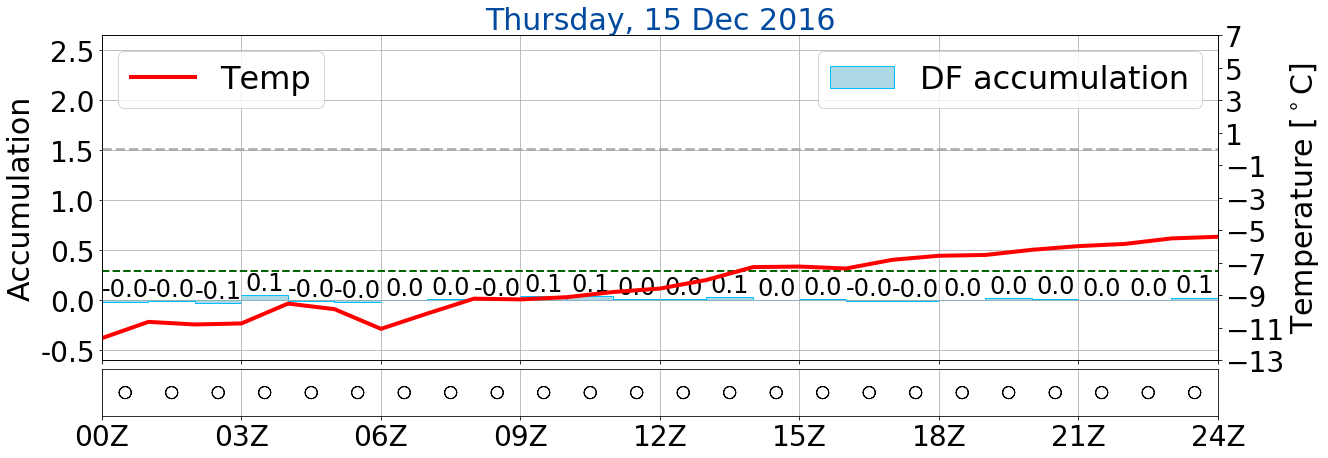

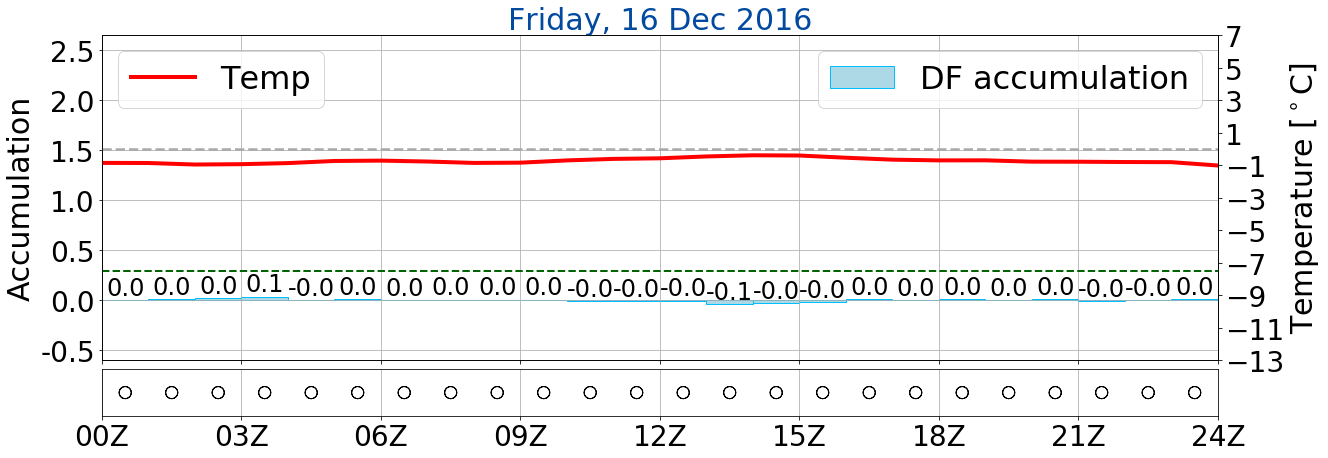

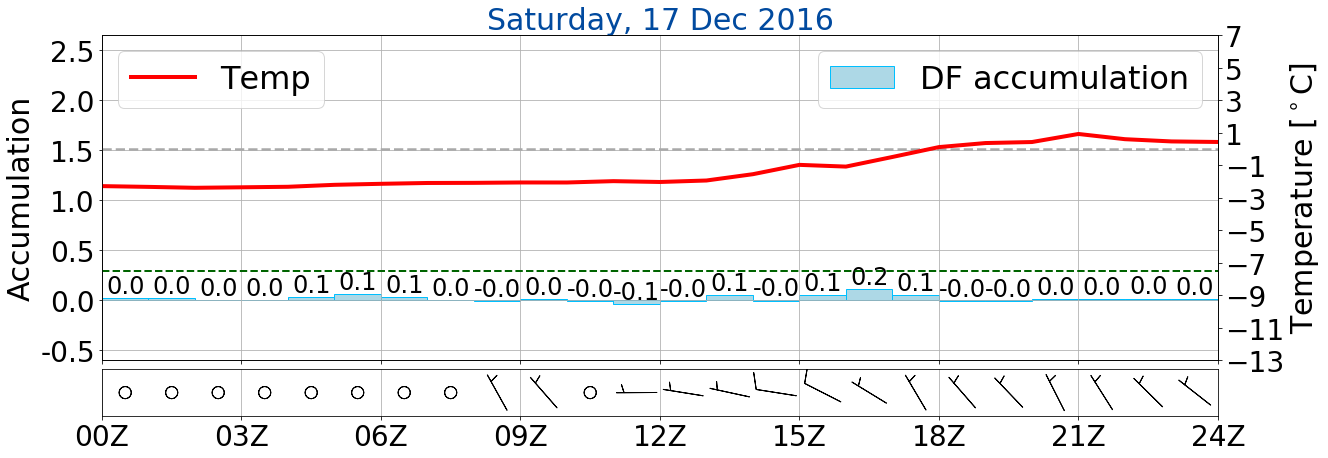

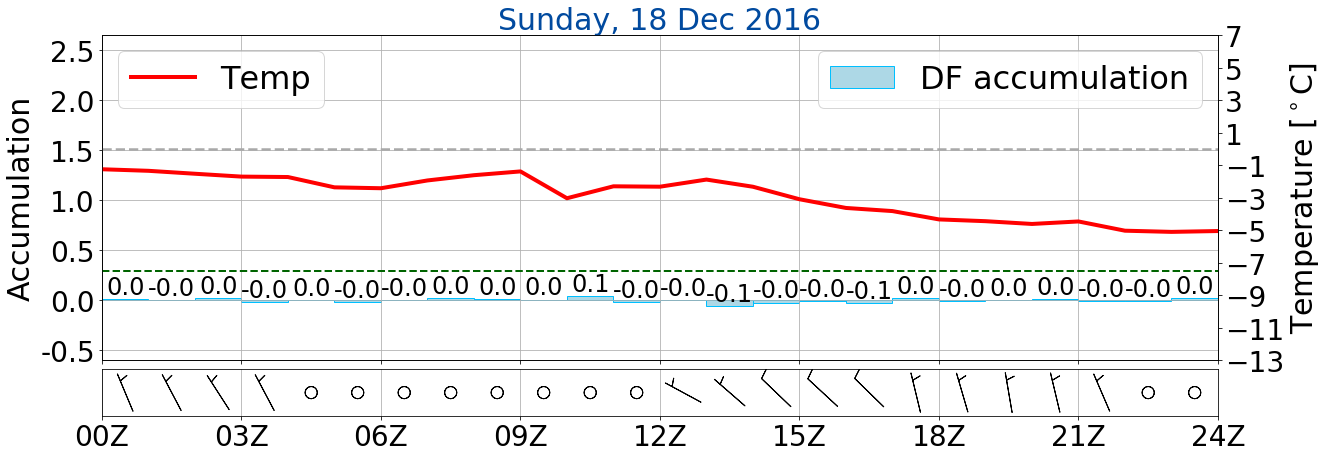

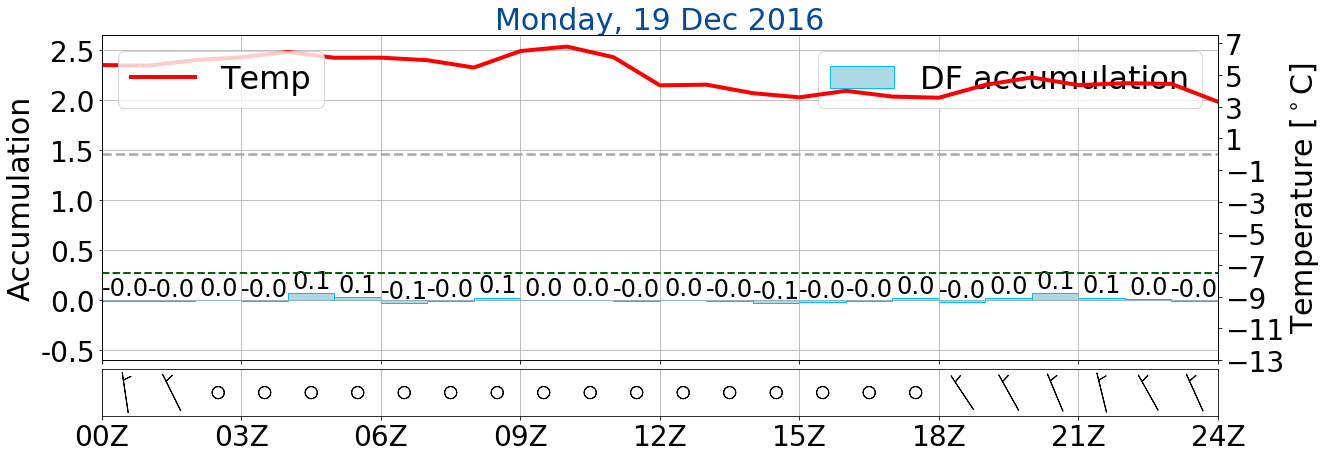

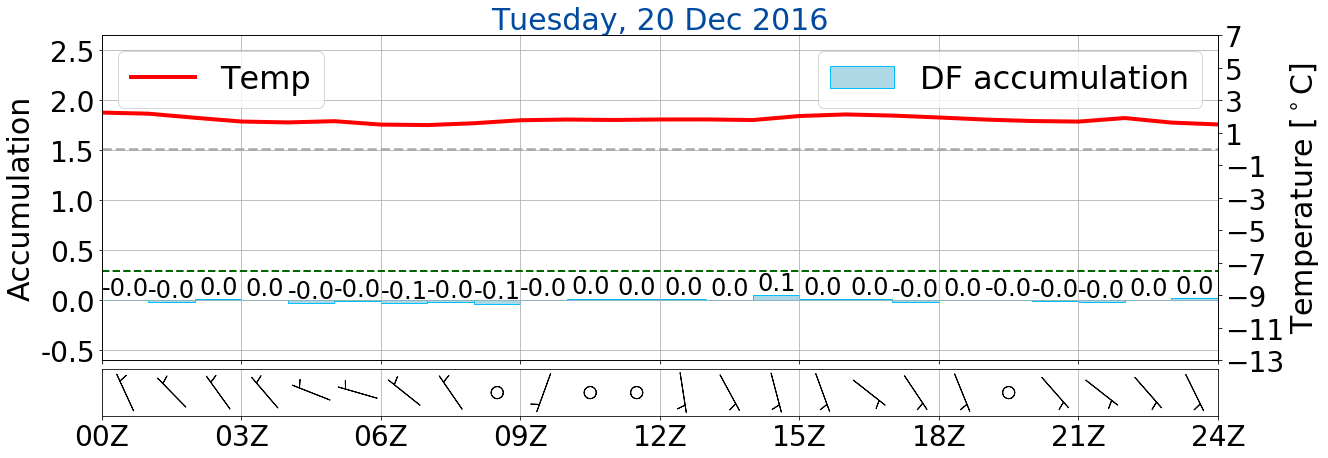

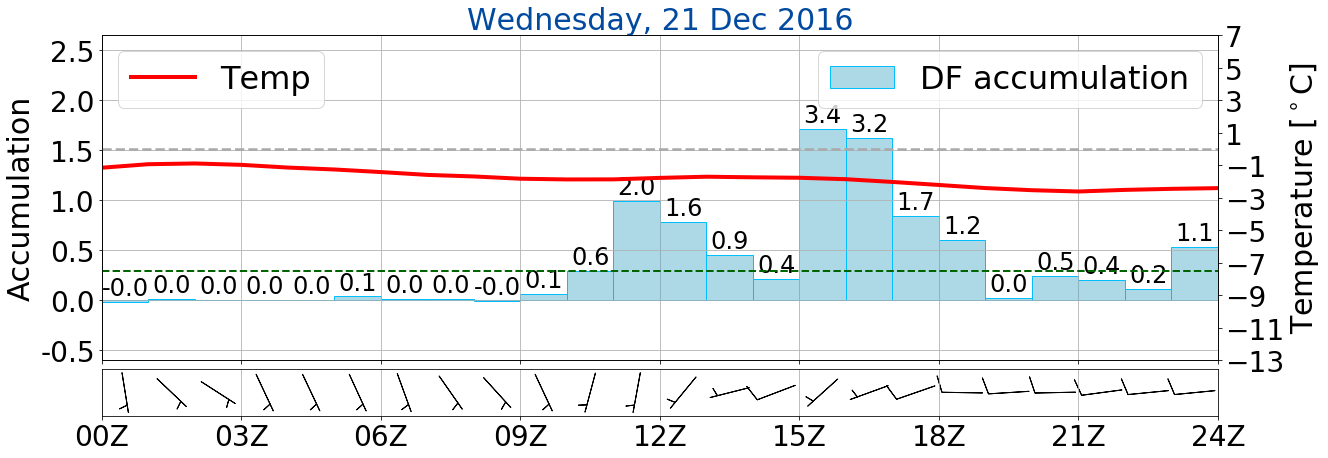

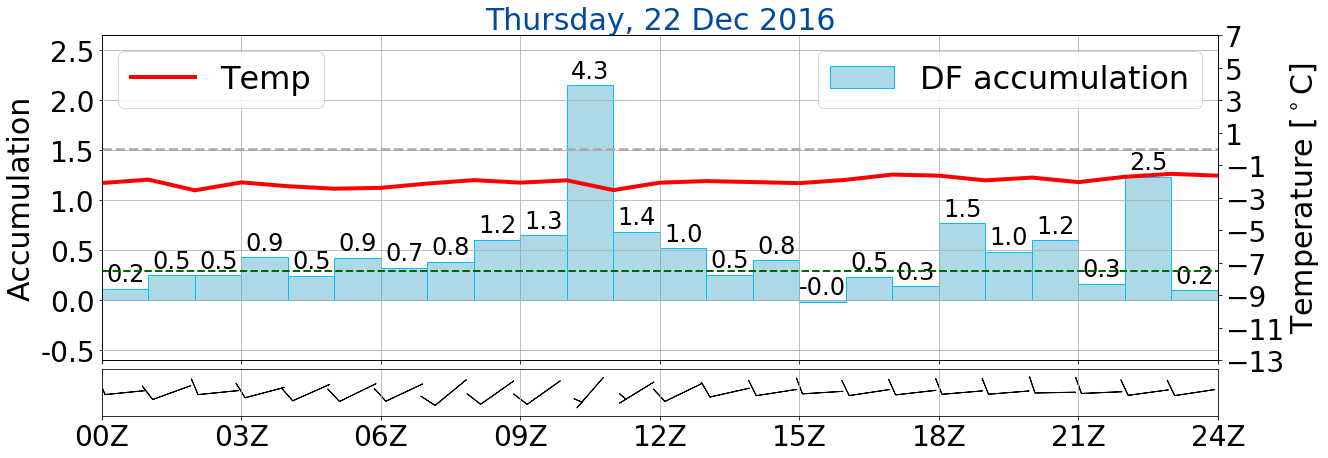

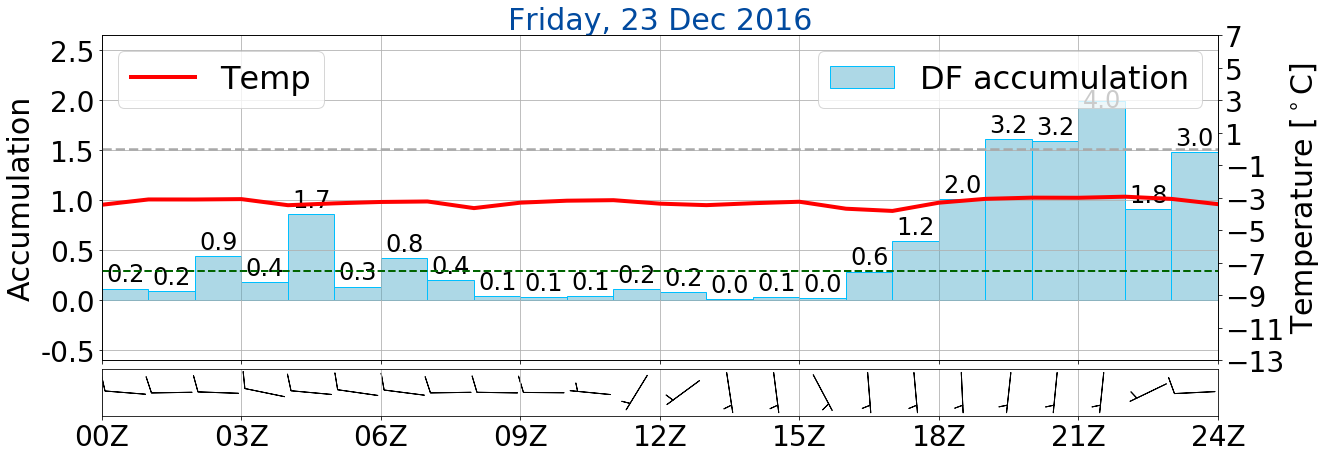

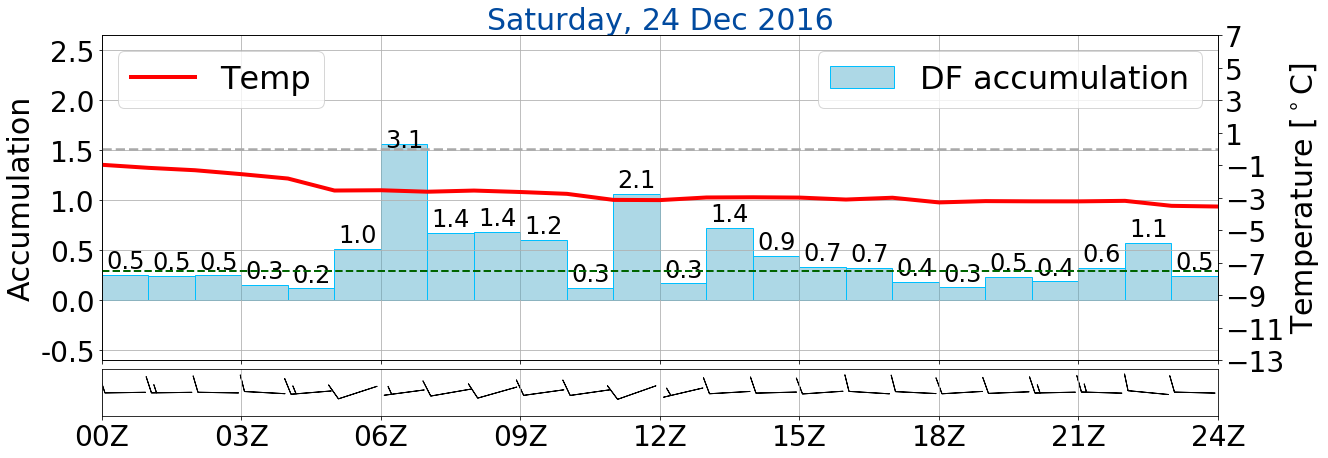

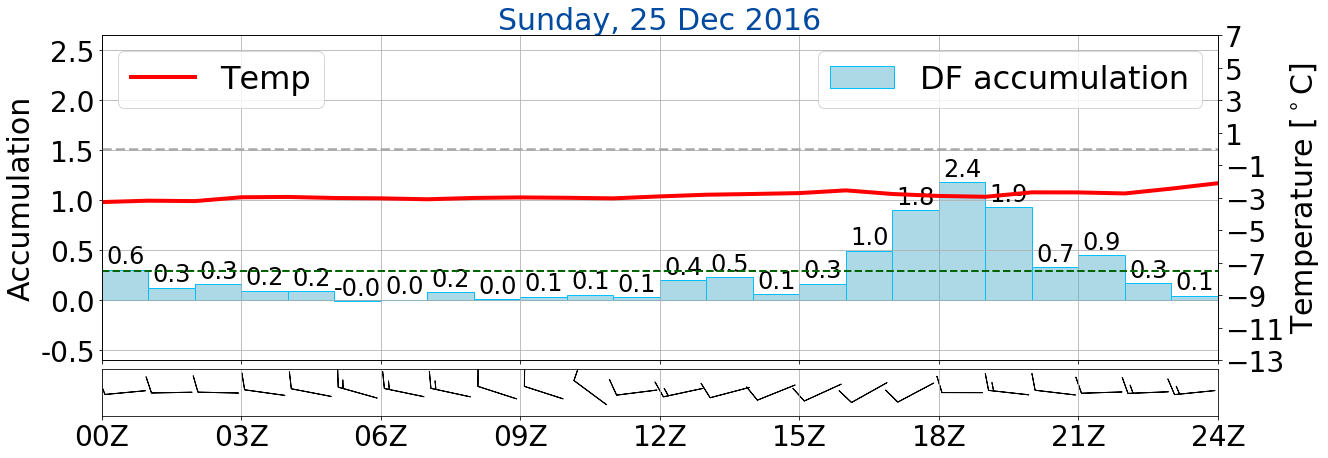

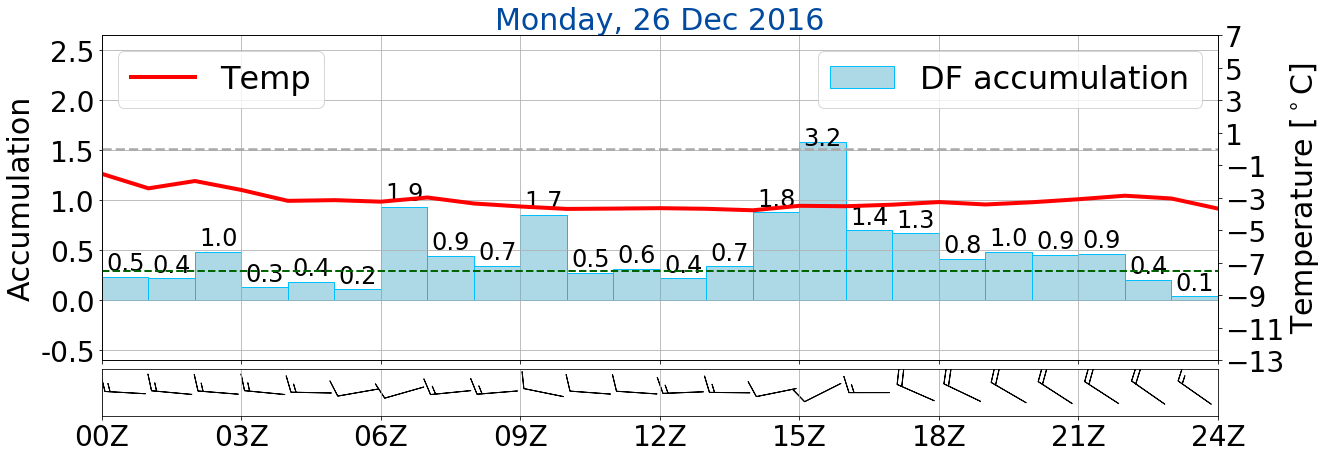

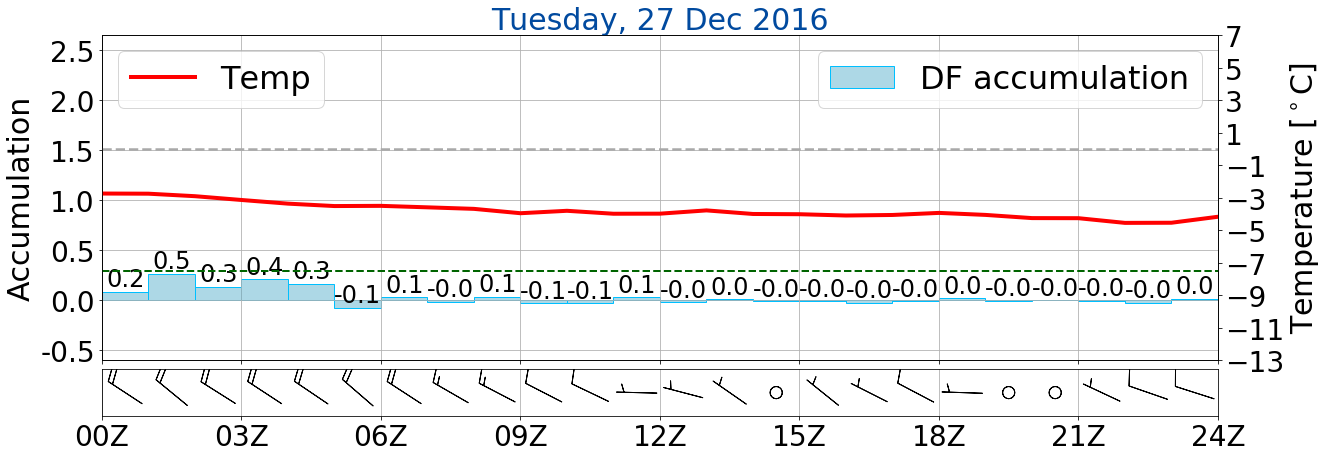

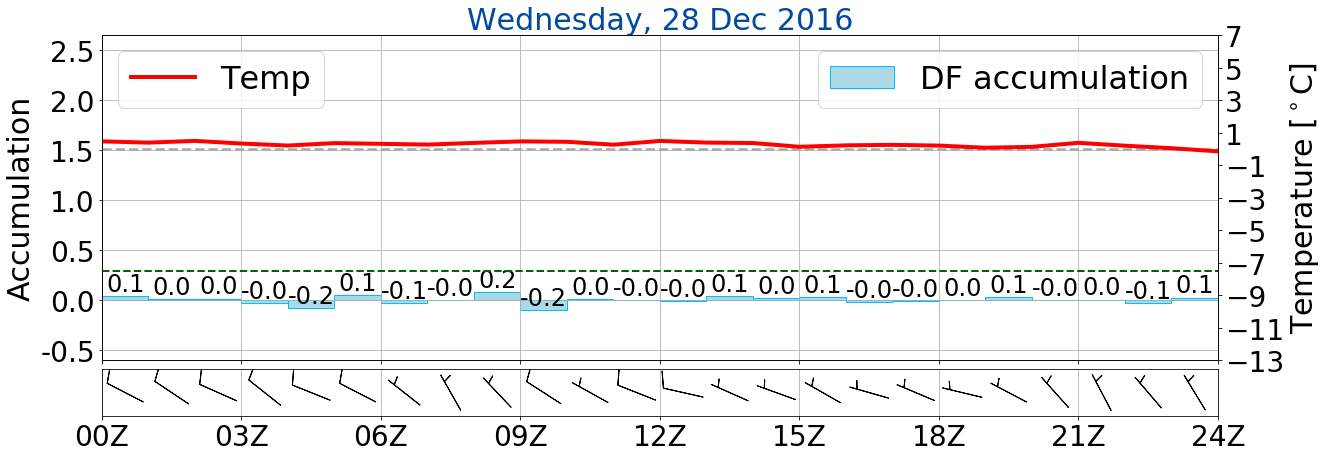

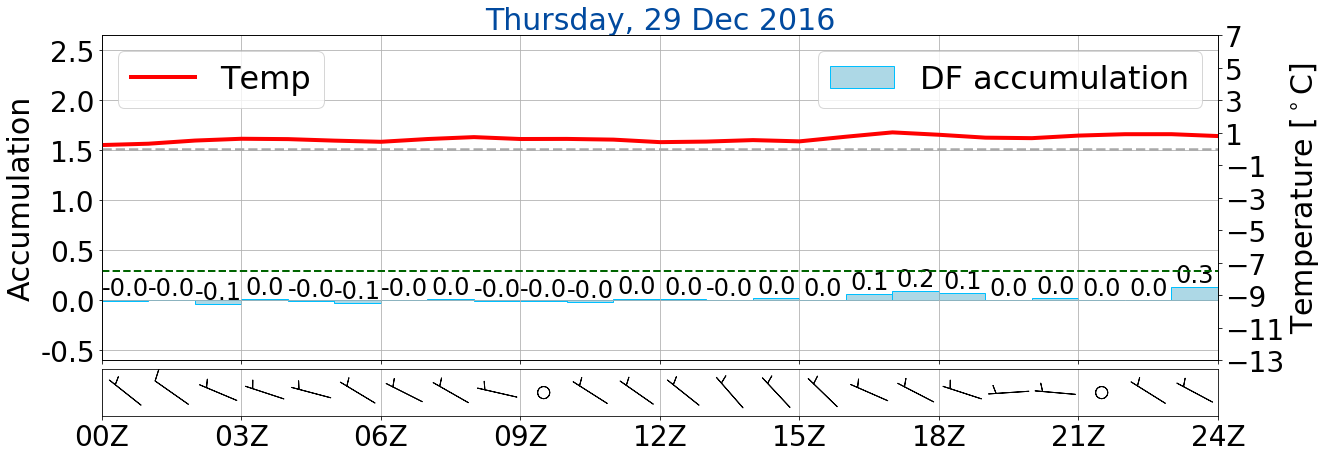

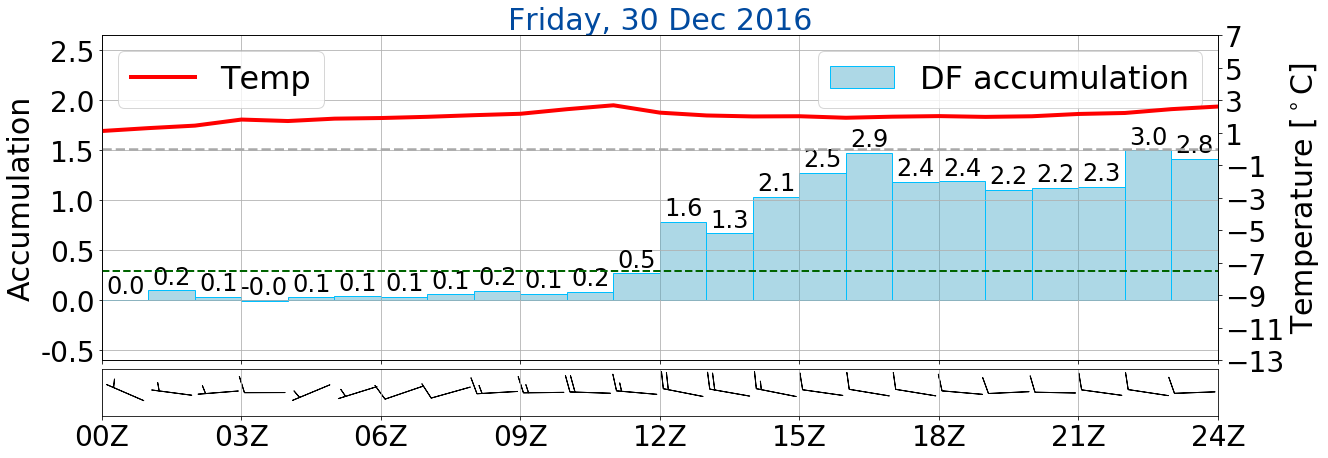

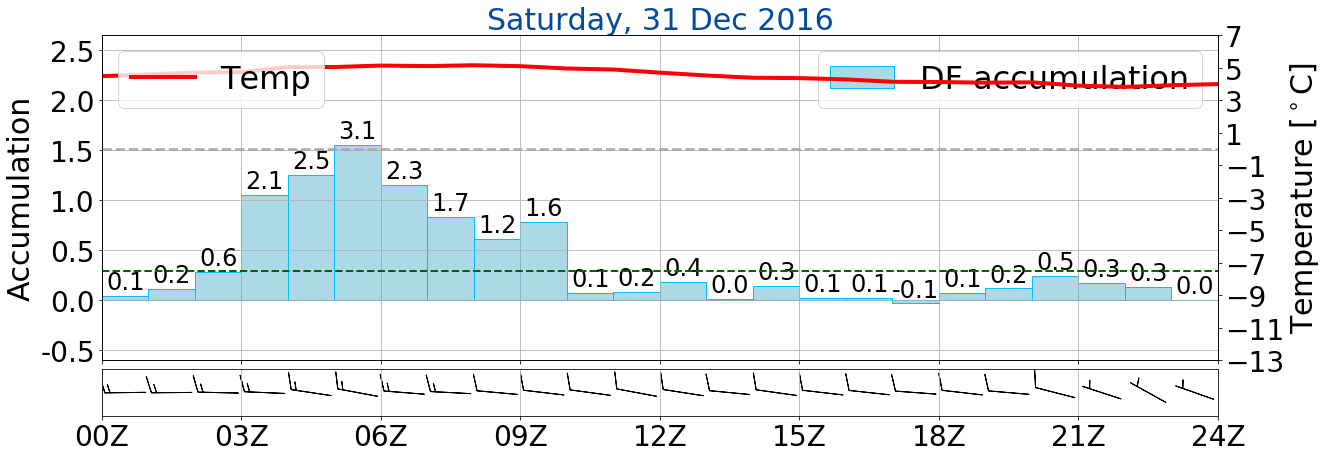

In [37]:
for k in range(4,31):
    my_date = date(year[:,k],month[:,k],day[:,k])
    calday = calendar.day_name[my_date.weekday()]
    calmon = calendar.month_abbr[int(month[:,k])]
    
    fig = plt.figure(figsize=(20,7))
    gs = gridspec.GridSpec(7,1)
    ax1 = fig.add_subplot(gs[:6,:])
    
    # find values wich are not NaN
    isNaN_P = np.isnan(df_60[:,k])   # Precipitation
    isNaN_T = np.isnan(t_mean[:,k])  # Temperature
    isNaN_U = np.isnan(u_wind_mean[:,k]) # U component Wind
    isNaN_V = np.isnan(v_wind_mean[:,k]) # V component Wind
    
    # Precipitation
    bar = ax1.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,k],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
    autolabel(bar, ax1)
    ax1.grid()
    plt.setp(ax1.get_xticklabels(), visible=False)
        
    
    # Temperature
    ax2 = ax1.twinx()
    line = ax2.plot(min_15[~isNaN_T,:], t_mean[~isNaN_T,k],color = 'r',label='Temp',linewidth = 4)
    ax2.axhline(y = 0., c ='darkgray', linewidth = 2.5, zorder = 0, linestyle = '--')
    ax2.axhline(y = -7.5, c ='darkgreen', linewidth = 2, zorder = 0, linestyle = '--')
    
    
    
    # labeling Precip
    ax1.set_ylabel('Accumulation',fontsize = 30)
    ax1.set_yticklabels(prec_tick,fontsize = 28)
    ax1.set_xticks(UTC)
    ax1.set_xticklabels(timer, fontsize=28)
    ax1.set_xlim([0,24*1/60])
    ax1.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
    ax1.legend(loc='upper right', fontsize=32)
    #ax1.spines['left'].set_color('deepskyblue')
    #ax1.yaxis.label.set_color('deepskyblue')
    #ax1.tick_params(axis='y',colors ='deepskyblue')
    
    # labeling Temp
    ax2.set_yticks(T)
    ax2.set_ylabel('Temperature [$^\circ$C]',fontsize = 30)
    ax2.tick_params(axis='both', which= 'major', labelsize=28)
    ##ax2.set_xticklabels(timer, fontsize=20)
    ax2.legend(loc='upper left', fontsize = 32)
    #ax2.spines['right'].set_color('r')
    #ax2.yaxis.label.set_color('r')
    #ax2.tick_params(axis='y',colors='r')
    
    # Wind
    # share x only
    ax3 = plt.subplot(gs[6,:])#, sharex=ax1)
    ax3.barbs(X[~isNaN_U],Y[~isNaN_V],u_wind_mean[~isNaN_U,k], v_wind_mean[~isNaN_V,k], length = 9, pivot='middle')
    #ax3.barbs(X,Y,u_wind[::60,8], v_wind[::60,8], length = 10, pivot='middle')
    # labeling Wind
    ax3.axes.get_yaxis().set_visible(False)
    ax3.tick_params(axis='both', which= 'major', labelsize=28)
    ax3.set_xticks(UTC)
    ax3.set_xticklabels(timer, fontsize=28)
    ax3.set_xlim([0,24*1/60])
    ax3.set_ylim([-0.001,0.001])
    ax3.grid()
        
    ax1.set_title('%s, %g %s %g' %(calday, (*day[:,k]), calmon, (*year[:,k])),fontsize=30, color=blue)
    ### Save
    plt.savefig('../Observations_results/Haukeli/T_P_U_%g%g%g.png' % ( (*year[:,k]), (*month[:,k]), (*day[:,k])))
    plt.show()
    plt.close()

In [38]:
############################################################################

In [39]:
# Autolabel bar plots
def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.05)
        else:
            label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%.1f' % (height),
                ha='center', va='bottom', fontsize=18)

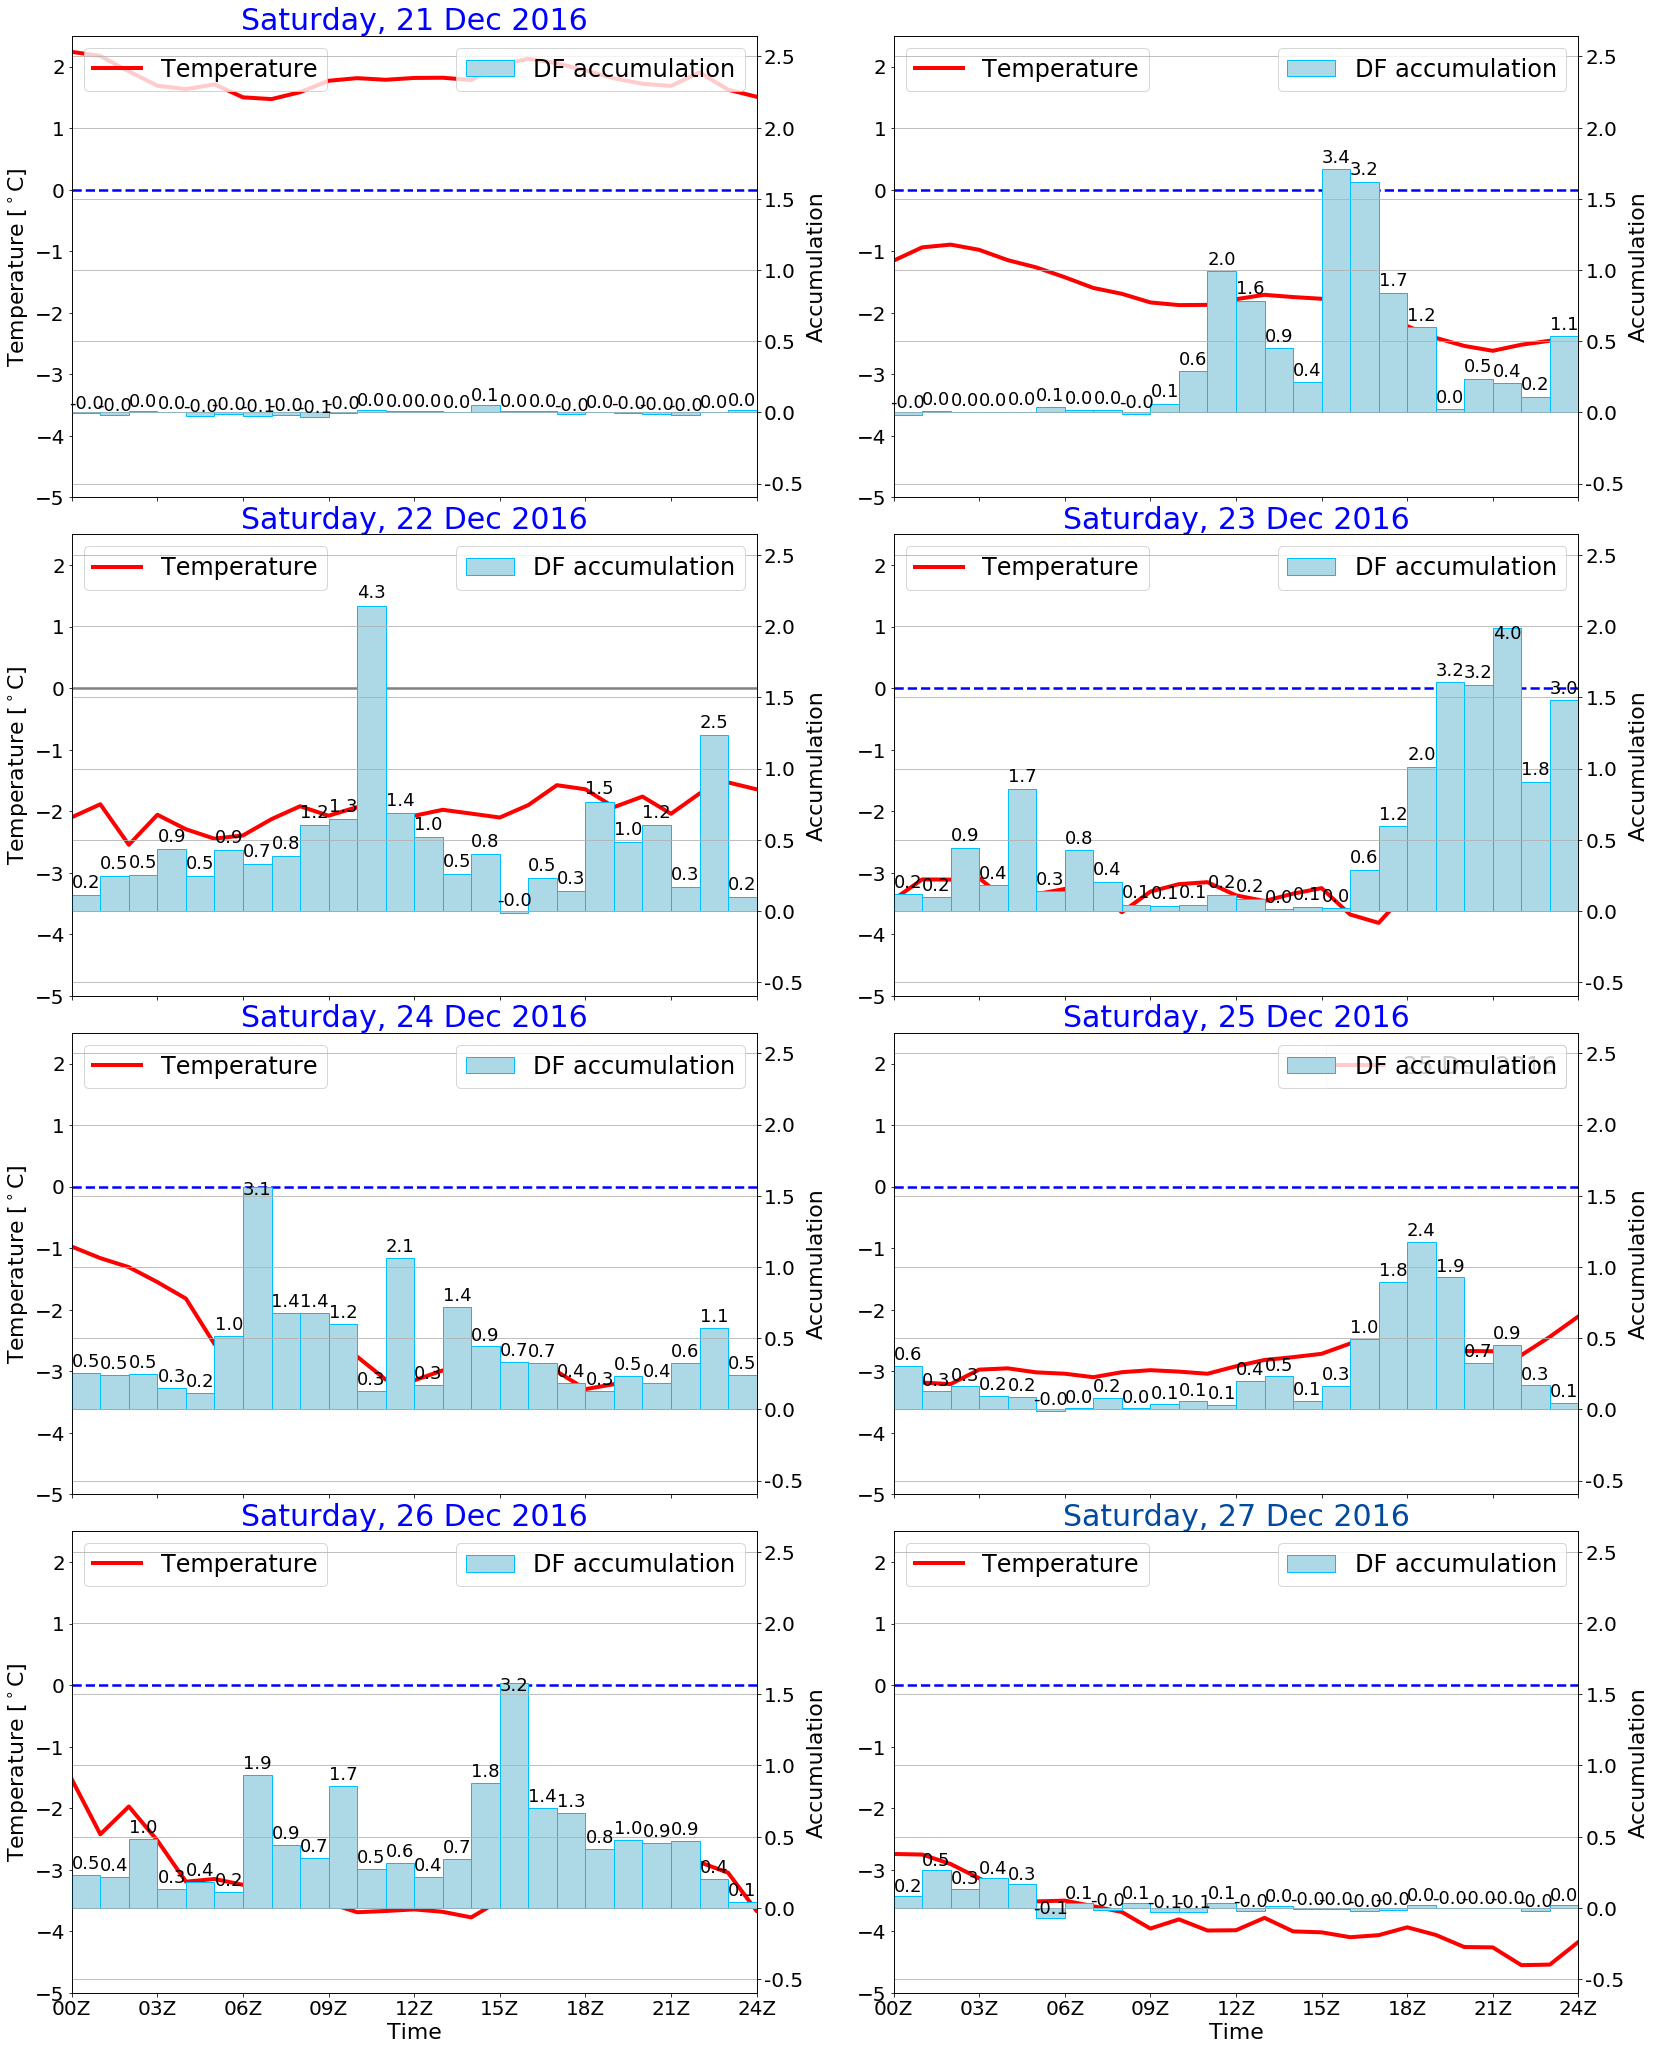

In [40]:
UTC = [1/60*float(0), \
       1/60*float(3), \
       1/60*float(6), \
       1/60*float(9), \
       1/60*float(12), \
       1/60*float(15), \
       1/60*float(18), \
       1/60*float(21), \
       1/60*float(24)]
timer = ['00Z', '03Z','06Z','09Z','12Z','15Z','18Z','21Z','24Z']

T = [-5, -4,-3,-2,-1,0,1,2,3,4,5]

fig = plt.figure(figsize=(27,36))
#ax = fig.add_subplot(1,1,1)

#plt.plot(min_15,t_mean[:,19:])
# row and column sharing
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Four subplots sharing both x/y axes
#f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
#f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, sharex='col', sharey='row',figsize=(20,16))

### 1. Subplot
#ax1 = plt.subplot(4,2,1)
ax1 = fig.add_subplot(4,2,1)
ax1.plot(min_15, t_mean[:,19],color = 'r',label='Temperature',linewidth = 4)

#bar2 = ax1.bar(min_15,df1_15[:,19], label='Precipitation',color='lightblue')
ax1.legend(loc='upper left', fontsize=24)
ax1.axhline(y = 0., c ='b', linewidth = 2.5, zorder = 0, linestyle = '--')

ax1.set_yticks(T)

ax1.set_ylabel('Temperature [$^\circ$C]',fontsize = 22)
ax1.tick_params(axis='both', which= 'major', labelsize=20)
ax1.set_xticklabels(timer, fontsize=20)

# make these tick labels invisible
plt.setp(ax1.get_xticklabels(), visible=False)

ax1.set_title('%s, %g %s %g' %(calday, (*day[:,19]), calmon, (*year[:,19])),fontsize=30, color='b')

# Precipitation
ax2 = ax1.twinx()
bar = ax2.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,19],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax2)
ax2.grid()

# labeling Precip
ax2.set_ylabel('Accumulation',fontsize = 22)
ax2.set_yticklabels(prec_tick,fontsize = 20)
ax2.set_xticks(UTC)
ax2.set_xticklabels(timer, fontsize=20)
ax2.set_xlim([0,24*1/60])
ax2.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax2.legend(loc='upper right', fontsize=24)



#############################################

### 2. Subplot
ax3 = fig.add_subplot(4,2,2, sharex=ax1, sharey=ax1)
ax3.plot(min_15, t_mean[:,20],color = 'r',label='Temperature',linewidth = 4)
ax3.legend(loc='upper left', fontsize=24)
ax3.tick_params(axis='both', which= 'major', labelsize=20)
ax3.axhline(y = 0., c ='b', linewidth = 2.5, zorder = 0, linestyle = '--')

# make these tick labels invisible
plt.setp(ax3.get_xticklabels(), visible=False)

ax1.set_title('%s, %g %s %g' %(calday, (*day[:,20]), calmon, (*year[:,20])),fontsize=30, color='b')

# Precipitation
ax4 = ax3.twinx()
bar = ax4.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,20],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax4)
ax4.grid()

# labeling Precip
ax4.set_ylabel('Accumulation',fontsize = 22)
ax4.set_yticklabels(prec_tick,fontsize = 20)
ax4.set_xticks(UTC)
ax4.set_xticklabels(timer, fontsize=20)
ax4.set_xlim([0,24*1/60])
ax4.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax4.legend(loc='upper right', fontsize=24)


#################################################

### 3. Subplot
ax5 = fig.add_subplot(4,2,3, sharex=ax1, sharey=ax1)
ax5.plot(min_15, t_mean[:,21],color = 'r',label='Temperature',linewidth = 4)
ax5.legend(loc='upper left', fontsize=24)
ax5.set_ylabel('Temperature [$^\circ$C]',fontsize = 22)
ax5.tick_params(axis='both', which= 'major', labelsize=20)
ax5.set_xticklabels(timer, fontsize=20)
ax5.axhline(y = 0., c ='gray', linewidth = 2.5, zorder = 0)#, linestyle = '--')

# make these tick labels invisible
plt.setp(ax5.get_xticklabels(), visible=False)

ax5.set_title('%s, %g %s %g' %(calday, (*day[:,21]), calmon, (*year[:,21])),fontsize=30, color='b')


# Precipitation
ax6 = ax5.twinx()
bar = ax6.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,21],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax6)
ax6.grid()

# labeling Precip
ax6.set_ylabel('Accumulation',fontsize = 22)
ax6.set_yticklabels(prec_tick,fontsize = 20)
ax6.set_xticks(UTC)
ax6.set_xticklabels(timer, fontsize=20)
ax6.set_xlim([0,24*1/60])
ax6.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax6.legend(loc='upper right', fontsize=24)




# make these tick labels invisible
#plt.setp(ax2.get_xticklabels(), visible=False)

############################################

### 4. Subplot
ax7 = fig.add_subplot(4,2,4, sharex=ax1, sharey=ax1)
ax7.plot(min_15, t_mean[:,22],color = 'r',label='Temperature',linewidth = 4)
ax7.legend(loc='upper left', fontsize=24)
ax7.tick_params(axis='both', which= 'major', labelsize=20)
ax7.axhline(y = 0., c ='b', linewidth = 2.5, zorder = 0, linestyle = '--')

# make these tick labels invisible
plt.setp(ax7.get_xticklabels(), visible=False)

ax7.set_title('%s, %g %s %g' %(calday, (*day[:,22]), calmon, (*year[:,22])),fontsize=30, color='b')

# Precipitation
ax8 = ax7.twinx()
bar = ax8.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,22],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax8)
ax8.grid()

# labeling Precip
ax8.set_ylabel('Accumulation',fontsize = 22)
ax8.set_yticklabels(prec_tick,fontsize = 20)
ax8.set_xticks(UTC)
ax8.set_xticklabels(timer, fontsize=20)
ax8.set_xlim([0,24*1/60])
ax8.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax8.legend(loc='upper right', fontsize=24)


############################################



### 5. Subplot
ax9 = fig.add_subplot(4,2,5, sharex=ax1, sharey=ax1)
ax9.plot(min_15, t_mean[:,23],color = 'r',label='Temperature',linewidth = 4)
ax9.legend(loc='upper left', fontsize=24)
ax9.set_ylabel('Temperature [$^\circ$C]',fontsize = 22)
ax9.tick_params(axis='both', which= 'major', labelsize=20)
ax9.set_xticklabels(timer, fontsize=20)
ax9.axhline(y = 0., c ='b', linewidth = 2.5, zorder = 0, linestyle = '--')

# make these tick labels invisible
plt.setp(ax9.get_xticklabels(), visible=False)

ax9.set_title('%s, %g %s %g' %(calday, (*day[:,23]), calmon, (*year[:,23])),fontsize=30, color='b')



# Precipitation
ax10 = ax9.twinx()
bar = ax10.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,23],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax10)
ax10.grid()

# labeling Precip
ax10.set_ylabel('Accumulation',fontsize = 22)
ax10.set_yticklabels(prec_tick,fontsize = 20)
ax10.set_xticks(UTC)
ax10.set_xticklabels(timer, fontsize=20)
ax10.set_xlim([0,24*1/60])
ax10.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax10.legend(loc='upper right', fontsize=24)

############################################



### 6. Subplot
ax11 = fig.add_subplot(4,2,6, sharex=ax1, sharey=ax1)
ax11.plot(min_15, t_mean[:,24],color = 'r',label='25 Dec 2016',linewidth = 4)
ax11.legend(loc='best', fontsize=24)
ax11.tick_params(axis='both', which= 'major', labelsize=20)
ax11.axhline(y = 0., c ='b', linewidth = 2.5, zorder = 0, linestyle = '--')

# make these tick labels invisible
plt.setp(ax11.get_xticklabels(), visible=False)

ax11.set_title('%s, %g %s %g' %(calday, (*day[:,24]), calmon, (*year[:,24])),fontsize=30, color='b')



# Precipitation
ax12 = ax11.twinx()
bar = ax12.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,24],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax12)
ax12.grid()

# labeling Precip
ax12.set_ylabel('Accumulation',fontsize = 22)
ax12.set_yticklabels(prec_tick,fontsize = 20)
ax12.set_xticks(UTC)
ax12.set_xticklabels(timer, fontsize=20)
ax12.set_xlim([0,24*1/60])
ax12.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax12.legend(loc='upper right', fontsize=24)

############################################



### 7. Subplot
ax13 = fig.add_subplot(4,2,7, sharex=ax1, sharey=ax1)
ax13.plot(min_15, t_mean[:,25],color = 'r',label='Temperature',linewidth = 4)
ax13.legend(loc='upper left', fontsize=24)
ax13.set_ylabel('Temperature [$^\circ$C]',fontsize = 22)
ax13.tick_params(axis='both', which= 'major', labelsize=20)
ax13.set_xticklabels(timer, fontsize=20)
ax13.axhline(y = 0., c ='b', linewidth = 2.5, zorder = 0, linestyle = '--')

ax13.set_title('%s, %g %s %g' %(calday, (*day[:,25]), calmon, (*year[:,25])),fontsize=30, color='b')

# Precipitation
ax14 = ax13.twinx()
bar = ax14.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,25],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax14)
ax14.grid()

# labeling Precip
ax14.set_ylabel('Accumulation',fontsize = 22)
ax14.set_yticklabels(prec_tick,fontsize = 20)
ax14.set_xticks(UTC)
ax14.set_xticklabels(timer, fontsize=20)
ax14.set_xlim([0,24*1/60])
ax14.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax14.legend(loc='upper right', fontsize=24)

############################################





### 8. Subplot
ax15 = fig.add_subplot(4,2,8, sharex=ax1, sharey=ax1)
ax15.plot(min_15, t_mean[:,26],color = 'r',label='Temperature',linewidth = 4)
ax15.legend(loc='upper left', fontsize=24)
ax15.tick_params(axis='both', which= 'major', labelsize=20)
ax15.axhline(y = 0., c ='b', linewidth = 2.5, zorder = 0, linestyle = '--')

ax15.set_title('%s, %g %s %g' %(calday, (*day[:,26]), calmon, (*year[:,26])),fontsize=30, color=blue)

# Precipitation
ax16 = ax15.twinx()
bar = ax16.bar(min_60[~isNaN_P,:],df_60[~isNaN_P,26],width=1/60.,align='edge',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
autolabel(bar, ax16)
ax16.grid()

# labeling Precip
ax16.set_ylabel('Accumulation',fontsize = 22)
ax16.set_yticklabels(prec_tick,fontsize = 20)
ax16.set_xticks(UTC)
ax16.set_xticklabels(timer, fontsize=20)
ax16.set_xlim([0,24*1/60])
ax16.set_ylim([np.nanmin(df_60)-1,np.nanmax(df_60)+1])
ax16.legend(loc='upper right', fontsize=24)

############################################






#####
ax1.set_xlim([0,24*1/60])
ax1.set_ylim([-5,2.5])

ax13.set_xticks(UTC),                  ax15.set_xticks(UTC)
ax13.set_xlabel('Time',fontsize = 22), ax15.set_xlabel('Time',fontsize = 22)



#ax1.grid(), ax2.grid(), ax3.grid(), ax4.grid()
#ax5.grid(), ax6.grid(), ax7.grid(), ax8.grid()




# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0.08)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)



plt.show()                    